In [1]:
import glob
import os
import pandas as pd
from PIL import Image, ImageOps
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# load training, testing and validation data
def get_datasets(img_path, csvfile, folders):
    
    x = []
    y = []
    
    # read csv table, get filename and label
    data = pd.read_csv(csvfile, header=None)
    filenames = data.iloc[:, 0].tolist()
    labels = data.iloc[:, 1].tolist()
    
    #
    for fn,lb in zip(filenames,labels):
        img = Image.open(os.path.join(img_path,folders[lb],fn))          
        img = np.array(img) / 255. 
        # numpy HxWxC to Torch CxHxW
        img = np.transpose(img,(2,0,1))
        x.append(img)
        y.append(lb)
        
    
    print(folders[0]+':'+str(y.count(0)))
    print(folders[1]+':'+str(y.count(1)))
    
    return x, y


def train_test_load(img_dir, folders, csv_train, csv_test):
    
    # load images and labels describes in csv tables
    x_train, y_train = get_datasets(img_dir, csv_train, folders)
    x_test, y_test = get_datasets(img_dir, csv_test, folders)

    # convert to torch
    x_train = torch.from_numpy(np.array(x_train)).float()
    y_train = torch.from_numpy(np.array(y_train)).long()
    x_test = torch.from_numpy(np.array(x_test)).float()
    y_test = torch.from_numpy(np.array(y_test)).long()

    # torch data set
    trainset = TensorDataset(x_train, y_train)
    testet = TensorDataset(x_test, y_test)

    # training and testing loader
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    testloader = DataLoader(testet, batch_size=1000, shuffle=False)
    
    # check torch dimension
    print('training set')
    print(x_train.shape)
    print(y_train.shape)

    # check torch dimension
    print('testing set')
    print(x_test.shape)
    print(y_test.shape)
    
    return trainloader, testloader


# CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(12 * 12 * 64, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    
def cnn_train_test(trainloader, testloader, conv_net, criterion, optimizer): 
    # training of cnn model
    l = []
    e = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = conv_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                e.append(epoch + 1)
                l.append(running_loss / 100)
                running_loss = 0.0

    print('Finished Training')

    # plot loss over epochs
    plt.plot(range(1,epochs+1,1),l[::6])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()


    # training accuracy metrices
    correct = 0
    total = 0
    classes = ('Uninfected', 'Parasitized')
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            outputs = conv_net(images)
            _, predicted = torch.max(outputs, 1)

            # total accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # accuracy on classes
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    print('Train Accuracy : ')
    print(float(correct)/float(total))

    for i in range(nb_classes):
        print('Train Accuracy of %5s : ' % (classes[i]))
        print(float(class_correct[i]) / float(class_total[i]))


    # testing  accuracy metrices
    correct = 0
    total = 0
    classes = ('Uninfected', 'Parasitized')
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    confusion_matrix_cnn_bw = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = conv_net(images)
            _, predicted = torch.max(outputs, 1)

            # accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # accuracy on classes
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            # confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                    confusion_matrix_cnn_bw[t.long(), p.long()] += 1


    accuracy_cnn_bw = float(correct) / float(total)      
    print('Test Accuracy : ')
    print(accuracy_cnn_bw)           

    for i in range(nb_classes):
        print('Test Accuracy of %5s : ' % (classes[i]))
        print(float(class_correct[i]) / float(class_total[i]))  

    print('Confusion Matrix : ')
    confusion_matrix_cnn_bw = confusion_matrix_cnn_bw.numpy()
    print(confusion_matrix_cnn_bw)


    tp = confusion_matrix_cnn_bw[1,1]
    fp = confusion_matrix_cnn_bw[0,1]
    fn = confusion_matrix_cnn_bw[1,0]
    precision_cnn_bw=tp/(tp+fp)
    print('Precision : '+str(precision_cnn_bw))

    recall_cnn_bw = tp/(tp+fn)
    print('Recall : '+str(recall_cnn_bw))

dz50_pad_Uninfected:11023
dz50_pad_Parasitized:11023
dz50_pad_Uninfected:2756
dz50_pad_Parasitized:2756
training set
torch.Size([22046, 3, 50, 50])
torch.Size([22046])
testing set
torch.Size([5512, 3, 50, 50])
torch.Size([5512])
[1,   100] loss: 0.694
[1,   200] loss: 0.686
[1,   300] loss: 0.679
[1,   400] loss: 0.670
[1,   500] loss: 0.658
[1,   600] loss: 0.651
[2,   100] loss: 0.633
[2,   200] loss: 0.632
[2,   300] loss: 0.634
[2,   400] loss: 0.632
[2,   500] loss: 0.638
[2,   600] loss: 0.626
[3,   100] loss: 0.612
[3,   200] loss: 0.621
[3,   300] loss: 0.608
[3,   400] loss: 0.607
[3,   500] loss: 0.600
[3,   600] loss: 0.584
[4,   100] loss: 0.585
[4,   200] loss: 0.594
[4,   300] loss: 0.586
[4,   400] loss: 0.594
[4,   500] loss: 0.567
[4,   600] loss: 0.562
[5,   100] loss: 0.558
[5,   200] loss: 0.540
[5,   300] loss: 0.520
[5,   400] loss: 0.510
[5,   500] loss: 0.493
[5,   600] loss: 0.465
[6,   100] loss: 0.448
[6,   200] loss: 0.406
[6,   300] loss: 0.360
[6,   400] l

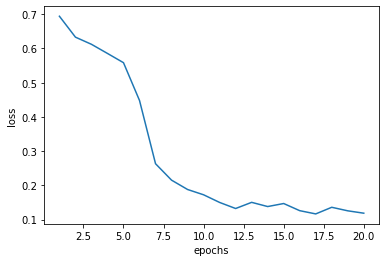

Train Accuracy : 
0.9587226707792796
Train Accuracy of Uninfected : 
0.954307116104869
Train Accuracy of Parasitized : 
0.9598874032371569
Test Accuracy : 
0.9517416545718432
Test Accuracy of Uninfected : 
1.0
Test Accuracy of Parasitized : 
0.9166666666666666
Confusion Matrix : 
[[2624.  132.]
 [ 134. 2622.]]
Precision : 0.9520697
Recall : 0.9513788


In [2]:
# folder directories
img_dir = os.path.join(os.getcwd(), 'cell_images')
pad_folders = ['dz50_pad_Uninfected', 'dz50_pad_Parasitized']
csv_train = 'train.csv'
csv_test = 'test.csv'
epochs = 20
nb_classes = 2

# load training and testing stream
trainloader, testloader = train_test_load(img_dir, pad_folders, csv_train, csv_test)
    
# create cnn model    
conv_net = ConvNet()

# optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(conv_net.parameters(), lr=0.01)
optimizer = optim.SGD(conv_net.parameters(), lr=0.001, momentum=0.9)

# cnn training and testing
cnn_train_test(trainloader, testloader, conv_net, criterion, optimizer)